# Neural Network Hedging:  From Implementation to Hyperparameter Tuning and Results Analysis
This notebook showcases the application of neural networks in the context of hedging. We start by implementing essential functions, then proceed with hyperparameter tuning, training, testing, and finally, presenting insightful visualizations of the obtained results.

![image](https://financialtribune.com/sites/default/files/field/image/17january/14_artificial.jpg)

### Model Architecture

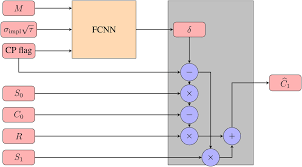


The architecture of the HedgeNet model can be described as follows:

1. Input Layers:
   - 'features': Input layer for the features used in the model.
   - 'cp_int': Input layer for the control parameter representing call or put (0 or 1).
   - 'V0': Input layer for the initial portfolio value.
   - 'S0': Input layer for the initial stock price.
   - 'S1': Input layer for the final stock price.
   - 'on_ret': Input layer for a one-day return of the stock.

2. Hidden Layers:
   - The model has multiple hidden layers, with the number of nodes specified by the 'nodes_per_layer' parameter during model building. Each hidden layer uses ReLU activation and L2 regularization.

3. Output Layer:
   - 'out_trainable': Output layer representing the predicted delta values before applying the control parameter.

4. Final Calculations:
   - The predicted delta values are subtracted from the 'cp_int' input to get the final delta values ('delta' layer).
   - The 'delta' values are then used to calculate intermediate results for cash flows and final portfolio value ('V1_hat').

5. Model Compilation:
   - The model is compiled using the Adam optimizer with the specified learning rate ('lr') and the loss function is Mean Squared Error ('mse').
   

### Implementation
Import essential Python libraries and modules that will be used throughout the notebook for various tasks. 

In [1]:
import sys
import os
import shutil
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import StandardScaler
import copy
import keras
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.backend import clear_session

### The HedgeNet Class

A class is defined called `HedgeNet`, which encapsulates methods for building, training, and using a neural network for hedging financial instruments. The class includes the following main methods:

1. `__init__`: The constructor initializes the class instance and sets the model attribute to None.

2. `build_model`: This method builds the neural network model for hedging using the provided parameters, such as the shape of the input features, the number of nodes per hidden layer, learning rate, activation functions, loss function, and regularization. 

3. `fit`: This method trains the neural network using the training data and evaluates its performance on the validation data. It takes as input the training and validation datasets, a list of feature names to be used during training, the target column name for V1, and optional parameters like the number of epochs and batch size.The function essentially performs the training of the neural network model using the provided training data (`train_data`) and validates its performance using the provided validation data (`val_data`). The model is trained for the specified number of epochs with the specified batch size, and the training metrics are recorded in the `history` object. The trained model can then be used for predictions on new data.

4. `calculate_delta`: This method calculates the delta using the trained model and a given DataFrame containing input features. It takes as input the DataFrame and a list of feature names to be used during inference and returns an array of predicted delta values.

The code uses the Keras library for building and training the neural network. It defines the architecture of the model with multiple hidden layers and different activation functions for each layer. The model is compiled with the Adam optimizer and the specified loss function. The `fit` method is used for training the model on the training data and evaluating it on the validation data. The `calculate_delta` method is used for making predictions using the trained model.

In [2]:
import keras
from keras.layers import Input, Dense, Subtract, Multiply, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

class HedgeNet:
    """
    This class encapsulates methods including building a neural network for hedging, fitting it with training data,
    and evaluating its performance on validation data.
    """

    def __init__(self):
        self.model = None

    def build_model(self, feature_shape, nodes_per_layer, lr=0.001, outact=None, loss='mse',
                    metrics=[None], reg_alpha=1e-4):
        """
        Build the neural network model for hedging.
        :param feature_shape: Shape of the input features.
        :param nodes_per_layer: A list representing the number of nodes for each hidden layer.
        :param lr: Learning rate for the optimizer.
        :param outact: Activation function for the output layer.
        :param loss: Loss function for training the model.
        :param metrics: Evaluation metrics used during training.
        :param reg_alpha: L2 regularization parameter for the dense layers.
        """
        # This line creates an input layer with the specified shape feature_shape for the
        # input features. The layer is named 'features' 
        features = Input(shape=feature_shape, dtype='float32', name='features')
        
        # This line creates the first hidden layer with nodes_per_layer[0] nodes. The
        # activation function used is ReLU, and L2 regularization with the strength of
        # reg_alpha is applied to the layer.
        x = Dense(nodes_per_layer[0], activation='relu', kernel_regularizer=l2(reg_alpha))(features)
        #  Initiate a loop to create additional hidden layers for each value in 
        # nodes_per_layer after the first element.
        for num_nodes in nodes_per_layer[1:]:       
            # Create a hidden layer with num_nodes nodes and applies ReLU activation and L2 
            # regularization.
            x = Dense(num_nodes, activation='relu', kernel_regularizer=l2(reg_alpha))(x)
            
        #  Create the output layer with a single node (output size 1).
        # The activation function for this layer is specified by outact, and the 
        # layer is named 'delta_before_flag'.
        out_trainable = Dense(1, activation=outact, name='delta_before_flag')(x)

        #  Creates an input layer for cp_int, which represents a flag representing call
        # or put (0 or 1)
        cp_int = Input((1,), dtype='float32', name='cp_int')
        
        # Create a layer that performs the element-wise subtraction between the output
        # layer out_trainable and the cp_int input. The layer is named 'delta'.
        delta = Subtract(name='delta')([out_trainable, cp_int])
        
        # V0 represents the initial portfolio value
        V0 = Input((1,), dtype='float32', name='V0')
        
        # S0 represents the initial stock price
        S0 = Input((1,), dtype='float32', name='S0')
        
        # S1 represents the final stock price
        S1 = Input((1,), dtype='float32', name='S1')
        
        # on_ret, which represents a one-day return of the stock.
        on_ret = Input((1,), dtype='float32', name='on_ret')
 
        # This line creates a layer that performs the element-wise multiplication between 
        # the S0 input and the 'delta' layer. The layer is named 'delta_S0'.
        delta_S0 = Multiply(name='delta_S0')([S0, delta])
        
        # This line creates a layer that performs the element-wise multiplication between
        # the S1 input and the 'delta' layer. The layer is named 'delta_S1'.
        delta_S1 = Multiply(name='delta_S1')([S1, delta])
        
        # This line creates a layer that performs the element-wise subtraction between
        # the V0 input and the 'delta_S0' layer. The layer is named 'cash0'.
        cash0 = Subtract(name='cash0')([V0, delta_S0])
        
        # This line creates a layer that performs the element-wise multiplication between
        # the 'cash0' layer and the on_ret input. The layer is named 'cash1'.
        cash1 = Multiply(name='cash1')([cash0, on_ret])
        
        # This line creates a layer that performs the element-wise addition between the 
        # 'cash1' layer and the 'delta_S1' layer. The layer is named 'V1_hat'.
        V1_hat = Add(name='V1_hat')([cash1, delta_S1])

        # This line creates the final model using the Keras Model class. It specifies the
        # input layers as [features, cp_int, V0, S0, S1, on_ret] and the output layer as
        # [V1_hat].
        self.model = Model(
            inputs=[features, cp_int, V0, S0, S1, on_ret],
            outputs=[V1_hat]
        )
        
        # This line compiles the model using the Adam optimizer with the specified learning
        # rate (lr), loss function (loss), and evaluation metrics (metrics). The model is
        # now ready for training.
        self.model.compile(
            optimizer=Adam(lr=lr),
            loss=loss,
            metrics=metrics
        )

    def fit(self, train_data, val_data, used_features, V1, epochs=1, batch_size=64):
        """
        Train the neural network using training data and evaluate its performance on validation data.
        :param train_data: Training data.
        :param val_data: Validation data.
        :param used_features: A list of feature names to be used for training.
        :param V1: The column name for the target V1.
        :param epochs: Number of epochs for training the model.
        :param batch_size: Batch size used during training.
        :return: History object with training metrics.
        """
        
        # A dictionary that contains the training data used for fitting the model.
        # The dictionary has two keys, 'x' and 't', where 'x' contains the input
        # features required for training, and 't' contains the target variable 'V1_hat'
        # representing the final portfolio value.
        train_pair = {
            'x': {
                'features': train_data[used_features].values,
                'cp_int': train_data['cp_int'].values,
                'V0': train_data['V0_n'].values,
                'S0': train_data['S0_n'].values,
                'S1': train_data['S1_n'].values,
                'on_ret': train_data['on_ret'].values
            },
            't': {'V1_hat': train_data[V1].values}
        }
        
        # A dictionary similar to train_pair, but containing the validation data used
        # for evaluating the model's performance.
        val_pair = {
            'x': {
                'features': val_data[used_features].values,
                'cp_int': val_data['cp_int'].values,
                'V0': val_data['V0_n'].values,
                'S0': val_data['S0_n'].values,
                'S1': val_data['S1_n'].values,
                'on_ret': val_data['on_ret'].values
            },
            't': {'V1_hat': val_data[V1].values}
        }

        # The training history object that captures the training metrics during the
        # training process.
        # V1_hat = cash1 + delta_S1
        
        '''
        x: The input data for training (train_pair['x']), which includes the features,
        control parameter, initial portfolio value, initial stock price, final stock price,
        and one-day return of the stock.

       y: The target data for training (train_pair['t']), which includes the target variable
       'V1_hat' representing the final portfolio value.

       batch_size: The number of samples per gradient update. It specifies how many samples
       are processed before the model's weights are updated.

       epochs: The number of times the entire dataset is passed forward and backward
       through the neural network during training.

       validation_data: The validation data used for evaluating the model's performance
       during training. It is a tuple containing the input data (val_pair['x']) and the
       target data (val_pair['t']).
       '''
        history = self.model.fit(
            x=train_pair['x'],
            y=train_pair['t'],
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(val_pair['x'], val_pair['t']),
        )
        return history

    def calculate_delta(self, df, used_features):
        """
        Calculate the delta using the trained model and given DataFrame.
        :param df: DataFrame containing the input features.
        :param used_features: A list of feature names to be used for inference.
        :return: Array of predicted delta values.
        """
        
        # This variable stores the name of the output layer of the neural network that
        # represents the predicted delta values.
        output_name = 'delta'
        
        
        '''
        A new submodel is created using the Keras functional API. It takes the following
        arguments:

        - inputs: A list of input layers required for inference, which includes 'features'
           and 'cp_int'.

        - outputs: The output layer of the submodel, which is the layer corresponding to
          the predicted delta values.

          The purpose of creating the submodel is to extract the predicted delta values 
          using specific input features from the original neural network model.
        '''
    
        submodel = Model(
            inputs=[self.model.get_layer('features').input,
                    self.model.get_layer('cp_int').input],
            outputs=self.model.get_layer(name=output_name).output)
        
        '''
         The function then uses the submodel to predict the delta values for the given
         DataFrame. It calls the predict method on the submodel and provides the input
         data for inference as a dictionary. The input data includes the features
         ('features') and the control parameter ('cp_int') from the DataFrame df.
        '''
        var = submodel.predict(
            x={'features': df[used_features].values, 'cp_int': df['cp_int'].values})
        
        # Return the predicted delta values as a flattened NumPy array
        return var.flatten()

### Implementation of Helpful Functions

The function below, takes a list of dataframes, standardizes the specified features in each dataframe using the given scaler, and returns a new list of dataframes with the standardized features. This process is useful for preparing data for machine learning models, as it ensures that all features have the same scale, which can improve the performance and stability of the models.


Code explanation:

1. The `standardize_feature` function takes three parameters: `list_of_dataframes`, `scaler`, and `original_features`.
2. The function creates new feature names with a `_t` suffix to represent the standardized features.
3. The `transformed_df` is appended to the `standardized_dataframes` list.
4. The function returns the list of standardized dataframes.

In [3]:
def standardize_feature(list_of_df, scaler, original_features):
    """
    Standardize the selected features in the given DataFrame or list of DataFrames using the provided scaler.
    :param list_of_df: DataFrame or list of DataFrames containing the data to be standardized.
    :param scaler: The scaler used for normalization.
    :param original_features: List of feature names to be standardized.
    :return: DataFrame or list of DataFrames with standardized features.
    """
    if not isinstance(list_of_df, list):
        # If a single DataFrame is provided, convert it to a list
        list_of_df = [list_of_df]

    trans_fea = [x + '_t' for x in original_features]
    std_res = []
    for df in list_of_df:
        # Copy the DataFrame to avoid modifying the original DataFrame
        var = df.copy()
        var[trans_fea] = scaler.transform(var[original_features])
        std_res.append(var)

    # If only one DataFrame was provided in the list, return it directly instead of a list
    if len(std_res) == 1:
        return std_res[0]
    return std_res

The `calculate_pnl` function is used to compute the PnL based on the predicted delta values and the provided DataFrame containing relevant features (`'S0_n'`, `'S1_n'`, `'V0_n'`, `'V1_n'`, and `'on_ret'`). The resulting PnL values indicate the profit or loss that would be obtained based on the predictions compared to the actual values.
Code explanation:

1. The `calculate_pnl` function takes three parameters: `df`, `delta`, and `target_column`.
2. The function calculates the Profit and Loss (PnL) based on the provided DataFrame (`df`) and the array of predicted delta values (`delta`).
3. It assumes short option and uses the columns `'S0_n'`, `'S1_n'`, `'V0_n'`, `'V1_n'`, and `'on_ret'` from the DataFrame.
4. The calculated PnL is the difference between the predicted `v1_hat` and the actual `v1`.
5. The `target_column` parameter allows you to specify the target column name in case you want to compare the PnL to a different column instead of the default `'V1_n'`.
6. The function returns a Series containing the calculated PnL values.

In [4]:
def calculate_pnl(df, delta, target_column='V1_n'):
    """
    Calculate the Profit and Loss (PnL) for a given DataFrame and delta values.
    We assume short option.
    :param df: DataFrame containing the required columns (S0_n, S1_n, V0_n, V1_n, on_ret).
    :param delta: Array of predicted delta values.
    :param target_column: The target column name to compare to (default is 'V1_n').
    :return: Series containing PnL values.
    """
    s0, s1 = df['S0_n'], df['S1_n']
    v0, v1 = df['V0_n'], df[target_column]
    on_ret = df['on_ret']
    
    v1_hat = (v0 - delta * s0) * on_ret + delta * s1
    pnl = v1_hat - v1
    return pnl

The `remove_columns_rename` function is responsible for removing specific columns from a dataframe and renaming certain columns based on provided dictionaries. It removes specific columns from the dataframe based on the provided `whole_dictionary` and renames certain columns using the `renaming_dictionary`. This allows for selective column removal and renaming in the dataframe.


Code explanation:

1. The function takes four parameters: `dataframe` (the input dataframe), `whole_dictionary` (a dictionary containing column information), `single_key` (a key from `whole_dictionary`), and `future_volume` (an optional parameter indicating whether to consider the future volume column).

2. It creates a copy of the `whole_dictionary` called `remove_frequency` to prevent modifying the original dictionary.

3. The function removes columns from the dataframe based on the values in `remove_frequency`. It iterates over the items in `remove_frequency` using a for loop.

4. For each item, it retrieves the tag (value[1]) and identifies columns in the dataframe that contain this tag. It uses a list comprehension to create a list of columns to be removed.

5. It then iterates over the columns to be removed and deletes them from the dataframe using the `del` keyword.

6. Next, it creates a dictionary called `renaming_dictionary` to store the renaming mappings for specific columns. The dictionary is populated based on the provided `single_key` and the values in `whole_dictionary`.

7. The dictionary maps the original column names to their corresponding new names. For example, if `whole_dictionary[single_key][1]` is equal to 2, it renames columns with the pattern `S2` to `S1` and so on.

8. If `future_volume` is `True`, it adds an additional mapping for the volume column.

9. Finally, it applies the renaming_dictionary to the dataframe using the `rename` function with the `inplace=True` parameter, effectively renaming the columns.

In [5]:
def remove_columns_rename(dataframe, whole_dictionary, single_key, future_volume=None):
    remove_frequency = whole_dictionary.copy()
    remove_frequency.pop(single_key)

    for key, value in remove_frequency.items():
        tag = value[1]
        columns_to_remove = [column for column in dataframe.columns if tag in column]
        for col in columns_to_remove:
            del dataframe[col]

    renaming_dictionary = {
        f"S{whole_dictionary[single_key][1]}": "S1",
        f"V{whole_dictionary[single_key][1]}": "V1",
        f"V{whole_dictionary[single_key][1]}_atm": "V1_atm",
        f"implvol{whole_dictionary[single_key][1]}": "implvol1",
        f"S{whole_dictionary[single_key][1]}_n": "S1_n",
        f"V{whole_dictionary[single_key][1]}_n": "V1_n",
        f"V{whole_dictionary[single_key][1]}_atm_n": "V1_atm_n"
    }

    if future_volume:
        renaming_dictionary[f"volume{whole_dictionary[single_key][1]}"] = "volume1"

    dataframe.rename(columns=renaming_dictionary, inplace=True)

Code explanation:

The `assign_data_tag` function is used to assign data tags to a specific period in the dataframe. It takes the following parameters:
- `dataframe`: The input dataframe to which the data tags will be assigned.
- `data_tag`: The tag indicating whether the data belongs to the train, validation, or test set.
- `data_period`: The period for which the data tags will be assigned.
- `data_offset`: The business offset used to determine the end of the assigned period.
- `start_date`: The start date of the assigned period.
- `end_date`: The end date of the assigned period.

The function first checks if the `data_offset` is a `pd.Timedelta` object. If it is, and the offset is less than or equal to 2 hours, the `data_end` is set to the `end_date`. Otherwise, the `data_end` is calculated by subtracting the `data_offset` from the `end_date`.

Next, the function filters the dataframe based on the specified date range using a boolean mask. The mask is created by checking if the date is within the start and end date range. The filtered rows in the dataframe are then assigned the corresponding data tag using the `loc` indexer and the `f'period{data_period}'` column.

Finally, the modified dataframe is returned with the assigned data tags.

In [6]:
def assign_data_tag(dataframe, data_tag=None, data_period=None, data_offset=None, start_date=None, end_date=None):
    """
    Assign data tags to a specified period in the dataframe.
    The data_tag indicates whether the data belongs to the train, validation, or test set.
    The assigned data_period is from the start_date to (end_date - business_offset).
    """
    # Check if the offset is a Timedelta object
    if isinstance(data_offset, pd.Timedelta):
        if data_offset <= pd.Timedelta('2 hours'):
            data_end = end_date
    else:
        data_end = end_date - data_offset
    # Filter the dataframe based on the specified date range
    date_range = (dataframe['date'] >= start_date) & (dataframe['date'] <= data_end)
    dataframe.loc[date_range, f'period{data_period}'] = data_tag
    return dataframe

The `add_custom_features` function takes an input dataframe and adds custom features to it.

Code explanation:

1. The function starts by creating a copy of the input dataframe using the `copy()` method to ensure that the original dataframe is not modified.

2. The first feature, custom feature 1 , is calculated by taking the square root of the `tau0` column and multiplying it by the `implvol0` column.

3. The second feature, custom feature 2 , is calculated by taking the square root of the `tau0` column.

4. The third feature, custom feature 3 , is calculated by taking the reciprocal of the square root of the `tau0` column.

5. The next set of features, custom feature 4, custom feature 5 , and custom feature 6 , are calculated for additional analysis. custom feature 4 is obtained by dividing the `vega_n` column by the product of the `S0_n` column (stock price) and the square root of the `tau0` column. custom feature 5  is the product of the `delta_bs` column and custom feature 4 , while custom feature 6 is obtained by squaring the `delta_bs` column and multiplying it by custom feature 4.

6. Finally, the modified dataframe with the added features is returned.

This code allows for the creation of custom features based on various calculations involving existing columns in the dataframe.

In [7]:
def add_custom_features(input_df):
    """
    Add custom features to the input dataframe.
    """
    # Create a copy of the dataframe
    df = input_df.copy()

    # Calculate the feature: tau0_implvol0
    df['tau0_implvol0'] = np.sqrt(df['tau0']) * df['implvol0']

    # Calculate the feature: sqrt_tau0
    df['sqrt_tau0'] = np.sqrt(df['tau0'])

    # Calculate the feature: 1_over_sqrt_tau
    df['1_over_sqrt_tau'] = 1 / np.sqrt(df['tau0'])

    # Calculate features for additional analysis
    df['vega_s'] = df['vega_n'] / (df['S0_n'] * np.sqrt(df['tau0']))
    df['delta_vega_s'] = df['delta_bs'] * df['vega_s']
    df['delta2_vega_s'] = (df['delta_bs']**2) * df['vega_s']
    return df
    

`modify_dataframe` function takes a dataframe, original size, minimum moneyness, and maximum moneyness as input. It removes in-the-money samples and shrinks the moneyness range in the dataframe. It prints information about the sample removal, such as the number of removed samples and the percentage of remaining data.

The `modify_dataframe` function shrinks the moneyness range by removing samples that fall outside the specified range.

code explanation:

1. It first checks whether each sample in the dataframe meets the criteria for being considered in-the-money. For call options, the condition is `df['cp_int'] == 0` and `df['M0'] < 1.001`. For put options, the condition is `df['cp_int'] == 1` and `df['M0'] > 0.999`. The bitwise OR operator (`|`) combines these conditions.

2. It calculates the number of samples that meet the in-the-money condition and calculates the percentage of removed samples based on the original size of the dataframe.

3. It filters the dataframe to keep only the samples that satisfy the in-the-money condition using the `loc` function.

4. Next, it checks whether each sample's moneyness value (`M0`) falls within the specified range (`min_moneyness` to `max_moneyness`). It uses the bitwise AND operator (`&`) to combine the conditions.

5. It calculates the number of samples that fall outside the moneyness range and calculates the corresponding removal percentage.

6. It filters the dataframe again to retain only the samples that fall within the desired moneyness range using the `loc` function.

7. Finally, it returns the modified dataframe.

In summary, the `modify_dataframe` function removes samples that are considered in-the-money or fall outside the specified moneyness range, effectively shrinking the moneyness range of the dataset.

In [8]:
def modify_dataframe(dataframe, original_size, min_moneyness, max_moneyness):
    """
    Remove in-the-money samples and shrink the moneyness range in the dataframe.
    Print information about sample removal.
    """

    # Remove in-the-money samples
    in_the_money = ((dataframe['cp_int'] == 0) & (dataframe['M0'] < 1.001)) | ((dataframe['cp_int'] == 1) & (dataframe['M0'] > 0.999))
    removed_count = dataframe.shape[0] - sum(in_the_money)
    removal_percentage = (removed_count / dataframe.shape[0]) * 100
    remaining_percentage = (sum(in_the_money) / original_size) * 100
    print(f"Removing in-the-money samples: {removed_count} samples ({removal_percentage:.2f}%) removed. "
          f"{remaining_percentage:.2f}% of data remaining. Current size of data: {sum(in_the_money)}.")

    dataframe = dataframe.loc[in_the_money]

    # Shrink moneyness range
    within_moneyness_range = (dataframe['M0'] >= min_moneyness - 0.001) & (dataframe['M0'] <= max_moneyness + 0.001)
    removed_count = dataframe.shape[0] - sum(within_moneyness_range)
    removal_percentage = (removed_count / dataframe.shape[0]) * 100
    remaining_percentage = (sum(within_moneyness_range) / original_size) * 100
    print(f"Shrinking moneyness range: {removed_count} samples ({removal_percentage:.2f}%) removed. "
          f"{remaining_percentage:.2f}% of data remaining. Current size of data: {sum(within_moneyness_range)}.")

    dataframe = dataframe.loc[within_moneyness_range]
    return dataframe

### Loading the Data

In this part we implement a code which  loads and cleans the training and validation data from a CSV file, applies data modifications and feature engineering operations, and prepares the `df_train` DataFrame for further processing in subsequent steps.

Implementation steps:

1. Define the directory path where the data files are located.
2. Read the CSV file named 'train_validation_data.csv' located in the specified directory into a Pandas DataFrame (`df`), while specifying the column to be used as the index (`index_col=0`) and parsing the 'date' column as datetime objects (`parse_dates=['date']`).
3. Store the original size of the DataFrame in the variable `original_size`.
4. Remove unnecessary columns and rename certain columns in the DataFrame using the `remove_columns_rename` function, passing the DataFrame (`df`), a dictionary containing column removal frequencies (`OFFSET_DICT`), and the desired frequency (`FREQ`).
5. Create a new column in the DataFrame named 'on_ret', which calculates the exponential of the product of the 'short_rate' column and a constant time interval (`DT`).
6. Apply tagging to the DataFrame using the `assign_data_tag` function. This assigns a tag of 0 for the first period and a tag of 1 for the second period, based on specified offset values and date ranges.
7. Print information about loading and cleaning the training and validation data, including the original size of the DataFrame before modifications.
8. Modify the DataFrame by removing in-the-money samples and shrinking the moneyness range using the `modify_dataframe` function, passing the DataFrame (`df`), the original size  and specified moneyness range limits.
9. Filter out rows where the 'V1' column is not NaN, and assign the resulting DataFrame to `df_train`.
10. Perform additional custom feature engineering on the `df_train` DataFrame using the `add_custom_features` function.

In [9]:
OFFSET_DICT = {
    '1D': [BDay(1), '_1D'],
    '2D': [BDay(2), '_2D']
}
DATE_BREAK = pd.Timestamp('2018/07/01') + pd.Timedelta('360D')
FREQ = '1D'
DT = 1 / 253.
MIN_M, MAX_M = 0.8, 1.5
seed = 42
UNDERLYINGPARAS = {
        's0': 2000.,
        'volatility': 0.2,
        'mu': 0.1,
        'start_date': pd.Timestamp('2018/07/01'),
        'end_date': pd.Timestamp('2018/07/01') + pd.Timedelta('450D')}

df = pd.read_csv('C:/Users/fatem/Desktop/hedging_project/data/train_validation_data.csv', index_col=0, parse_dates=['date'])
original_size = df.shape[0]

remove_columns_rename(df, OFFSET_DICT, FREQ)
df['on_ret'] = np.exp(df['short_rate'] * DT)

assign_data_tag(df, 0, 0, OFFSET_DICT[FREQ][0], UNDERLYINGPARAS['start_date'], DATE_BREAK)
assign_data_tag(df, 1, 0, OFFSET_DICT[FREQ][0], DATE_BREAK, UNDERLYINGPARAS['end_date'])

print("Load and clean the training and validation data.")
print(f'Original data size is {df.shape[0]}')

df = modify_dataframe(df, original_size, MIN_M, MAX_M)
bl = df['V1'].notna()
df_train = df.loc[bl]
df_train = add_custom_features(df_train)


Load and clean the training and validation data.
Original data size is 579717
Removing in-the-money samples: 293046 samples (50.55%) removed. 49.45% of data remaining. Current size of data: 286671.
Shrinking moneyness range: 0 samples (0.00%) removed. 49.45% of data remaining. Current size of data: 286671.


In [10]:
df_train

,date,S0,K,tau0,optionid,short_rate,M0,r,implvol0,V0,...,vanna_n,is_test_sample,on_ret,period0,tau0_implvol0,sqrt_tau0,1_over_sqrt_tau,vega_s,delta_vega_s,delta2_vega_s
15,2018-07-02,2000.000000,2000.0,0.055336,2,0.0,1.000000,0.0,0.2,37.534770,...,0.046910,False,1.0,0.0,0.047047,0.235236,4.251050,0.398832,0.203158,0.103486
23,2018-07-12,1998.273253,2000.0,0.023715,2,0.0,0.999137,0.0,0.2,23.709246,...,0.086651,False,1.0,0.0,0.030800,0.153998,6.493587,0.398910,0.197443,0.097726
24,2018-07-13,1997.590376,2000.0,0.019763,2,0.0,0.998795,0.0,0.2,21.234924,...,0.113522,False,1.0,0.0,0.028116,0.140580,7.113368,0.398777,0.194804,0.095163
30,2018-07-02,2000.000000,2005.0,0.055336,3,0.0,0.997506,0.0,0.2,35.134593,...,0.152719,False,1.0,0.0,0.047047,0.235236,4.251050,0.398768,0.194684,0.095047
38,2018-07-12,1998.273253,2005.0,0.023715,3,0.0,0.996645,0.0,0.2,21.376550,...,0.247278,False,1.0,0.0,0.030800,0.153998,6.493587,0.397194,0.183769,0.085024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579510,2019-08-30,2870.292079,2870.0,0.830040,2580,0.0,1.000102,0.0,0.2,208.203738,...,0.179860,False,1.0,1.0,0.182213,0.911065,1.097616,0.397270,-0.184127,0.085340
579564,2019-08-30,2870.292079,2865.0,0.909091,2583,0.0,1.001847,0.0,0.2,215.191095,...,0.169944,False,1.0,1.0,0.190693,0.953463,1.048809,0.396748,-0.181781,0.083288
579582,2019-08-30,2870.292079,2870.0,0.909091,2584,0.0,1.000102,0.0,0.2,217.870857,...,0.188256,False,1.0,1.0,0.190693,0.953463,1.048809,0.397113,-0.183390,0.084691
579636,2019-08-30,2870.292079,2865.0,1.007905,2587,0.0,1.001847,0.0,0.2,226.685962,...,0.180836,False,1.0,1.0,0.200789,1.003945,0.996071,0.396554,-0.180975,0.082591


### Select Features for Training

In  this part of the code we set the features and the subdirectory path based on the selected feature set, allowing the rest of the code to use the appropriate features and store the results in the correct subdirectory.

In [11]:
FEATURE_SET = 'normal_feature'

np.random.seed(seed)

if FEATURE_SET == 'normal_feature':
    original_features = ['M0', 'tau0_implvol0']

if FEATURE_SET == 'delta_vega':
    original_features = ['delta_bs', '1_over_sqrt_tau', 'vega_n']

if FEATURE_SET == 'delta_vega_vanna':
    original_features = ['delta_bs', '1_over_sqrt_tau', 'vega_n', 'vanna_n']

### Preprocessing

The code below is splitting the original DataFrame `df_train` into two separate DataFrames: `df_train` and `df_val`.

1. `df_val = df_train.loc[df_train['period0'] == 1].copy()`: This line creates a new DataFrame `df_val` by selecting rows from `df_train` where the value of the column 'period0' is equal to 1. The `.loc` method is used for label-based indexing, and the `.copy()` method is used to make a copy of the selected rows to ensure that `df_val` is independent of `df_train`.

2. `df_train = df_train.loc[df_train['period0'] == 0].copy()`: This line updates the `df_train` DataFrame by selecting rows from the original `df_train` where the value of the column 'period0' is equal to 0. The `.loc` method is again used for label-based indexing, and the `.copy()` method is used to make a copy of the selected rows.

After this operation, `df_train` will contain only those rows where 'period0' is equal to 0, and `df_val` will contain only those rows where 'period0' is equal to 1. This is a common technique used in machine learning to create separate training and validation datasets. The rows where 'period0' is 0 are used for training, and the rows where 'period0' is 1 are used for validation.

In [12]:
df_val = df_train.loc[df_train['period0'] == 1].copy()
df_train = df_train.loc[df_train['period0'] == 0].copy()

This code is performing feature scaling on the selected features of the DataFrames `df_train` and `df_val` using `StandardScaler`.

1. `used_features = [x + '_t' for x in original_features] + ['cp_int']`: This line creates a new list `used_features` by appending the suffix '_t' to each feature name in the `original_features` list and also includes the feature 'cp_int'. This suggests that '_t' suffix indicates the standardized version of the original feature names.

2. `scaler = StandardScaler().fit(X=df_train[original_features])`: This line initializes a `StandardScaler` object and fits it to the training data `df_train[original_features]`. The `StandardScaler` is used to compute the mean and standard deviation of each feature in `original_features`, which will be used later to scale the data.

3. `df_train = standardize_feature(df_train, scaler, original_features)`: This line applies the function `standardize_feature` to the DataFrame `df_train` using the previously fitted scaler and the `original_features` list. The function standardizes the selected features in `df_train` using the provided scaler, and the standardized features are added with the suffix '_t'.

4. `df_val = standardize_feature(df_val, scaler, original_features)`: Similarly, this line applies the same feature scaling to the DataFrame `df_val` using the previously fitted scaler and the `original_features` list. The selected features in `df_val` are standardized using the same scaling parameters obtained from the training data.

After these operations, both `df_train` and `df_val` will have their selected features standardized and appended with the '_t' suffix, and the 'cp_int' feature will be included in the standardized features. This preprocessing step ensures that the input features are on the same scale, which is a common requirement for many machine learning algorithms to work effectively.

In [13]:
used_features = [x + '_t' for x in original_features] + ['cp_int']

scaler = StandardScaler().fit(X=df_train[original_features])
df_train = standardize_feature(df_train, scaler, original_features)
df_val = standardize_feature(df_val, scaler, original_features)

In [14]:
used_features

['M0_t', 'tau0_implvol0_t', 'cp_int']

This code is part of a data preprocessing step for a Monte Carlo simulation dataset. The main purpose is to prepare the test set (`df_test`) for evaluation and analysis. 

1. `df_test = pd.read_csv(PATH, index_col=0, parse_dates=['date'])`: Reads the Monte Carlo data from the specified file (`test_data.csv`) into a DataFrame `df_test`. The 'date' column is parsed as datetime objects.

2. `remove_columns_rename(df_test, OFFSET_DICT, FREQ)`: Calls a function `remove_columns_rename` to remove irrelevant columns and rename the remaining columns in the `df_test` DataFrame based on some configuration dictionaries (`OFFSET_DICT` and `FREQ`).

3. `df_test['on_ret'] = np.exp(df_test['short_rate'] * DT)`: Calculates a new feature 'on_ret' by taking the exponential of the product of 'short_rate' and a parameter `DT`.

4. `assign_data_tag(df_test, 2, 0, OFFSET_DICT[FREQ][0], df_test['date'].min(), df_test['date'].max())`: Calls a function `assign_data_tag` to assign data tags to the test set based on some parameters and the 'date' column.

5. `original_size = df_test.shape[0]`: Records the original size (number of rows) of the test set.

6. `bl = df_test['V1'].notna()`: Creates a boolean mask `bl` that checks if the 'V1' column is not NaN (not missing).

7. `df_test = df_test.loc[bl]`: Removes rows from `df_test` where the 'V1' column is missing.

8. Prints information about the removal and the remaining samples.

9. `df_test = add_custom_features(df_test)`: Calls a function `add_custom_features` to add custom features to the test set `df_test`.

So we load a Monte Carlo dataset, preprocesses it by removing irrelevant rows, calculates new features and assigns data tags.

In [15]:
# Import Monte Carlo Set and Preprocessing

# Read the Monte Carlo data for the current set
df_test = pd.read_csv('C:/Users/fatem/Desktop/hedging_project/data/test_data.csv', index_col=0, parse_dates=['date'])

# Remove irrelevant columns and rename remaining columns
remove_columns_rename(df_test, OFFSET_DICT, FREQ)

# Calculate the 'on_ret' feature
df_test['on_ret'] = np.exp(df_test['short_rate'] * DT)

# Assign data tags for the test set
assign_data_tag(df_test, 2, 0, OFFSET_DICT[FREQ][0], df_test['date'].min(), df_test['date'].max())

# Record the original size of the test set
original_size = df_test.shape[0]

# Modify the test set by removing rows where S1 is not available
bl = df_test['V1'].notna()
df_test = df_test.loc[bl]

# Print information about sample removal
removal_count = original_size - sum(bl)
removal_percentage = (removal_count / original_size) * 100
remaining_percentage = (sum(bl) / original_size) * 100
print(f'We remove samples when S1 is not available. {removal_count} samples ({removal_percentage:.2f}%) are removed. '
      f'{remaining_percentage:.2f}% of data is left. Current size of data: {sum(bl)}.')

# Add custom features to the test set
df_test = add_custom_features(df_test)


We remove samples when S1 is not available. 2582 samples (1.89%) are removed. 98.11% of data is left. Current size of data: 133861.


### Hyperparameter Tuning
The purpose of this section is for tuning and training a neural network for a hedging model. We define functions to train and test the neural network with different hyperparameter settings, specifically focusing on the `reg_alpha` parameter. The code then loops over a set of predefined values for `reg_alpha`, trains the neural network with each value, and tests it on a test dataset. It keeps track of the best hyperparameter value for `reg_alpha` based on the lowest validation mean squared error (MSE). Finally, it prints the best hyperparameter value and plots the MSE history for each value of `reg_alpha`.

Code explanation:

1. The code starts with importing required libraries and defining some global variables like `best_hyperparams`, `best_val_loss`, and `best_model` to keep track of the best hyperparameters and model during training.

2. The function `plot_training_progress` is defined to plot the mean squared error (MSE) history during training and validation. It calculates the MSE and plots it.

3. The function `train_neural_network` is the core function used for training the neural network. It builds a neural network using the provided hyperparameters, fits it to the training data, and returns the training history.

4. The function `test_selected_model` is the core function used for testing the trained neural network on the test data. It builds the neural network with the best hyperparameters, loads the weights of the best model, calculates delta values for the test set, and returns the delta values.

5. The main part of the code contains the hyperparameters (`hypers`) and the list of values to tune (`set_of_values`). It also initializes dictionaries to store the MSE history for each alpha (`mse_history`) and the best hyperparameter values for each parameter (`best_hyperparameter_value`).

6. The code then loops over the `set_of_values` and tunes the hyperparameter `reg_alpha` by training the neural network and testing it on the test set. It saves the MSE history for each value of `reg_alpha`.

7. After the loop, the best hyperparameter values for each parameter are printed.

8. Finally, the function `plot_training_progress` is called to plot the MSE history for each value of `reg_alpha`.

Note that the provided code is for tuning a single hyperparameter (`reg_alpha`) using the value set `[1e-2, 1e-3, 1e-4, 1e-5, 1e-6]`. If we have multiple hyperparameters to tune, we would need to modify the code accordingly.

Epoch 1/150
3463/3463 [==============================] - 4s 1ms/step - loss: 0.1920 - mean_squared_error: 0.0153 - val_loss: 0.0580 - val_mean_squared_error: 0.0022
Epoch 2/150
3463/3463 [==============================] - 4s 1ms/step - loss: 0.0255 - mean_squared_error: 0.0036 - val_loss: 0.0085 - val_mean_squared_error: 0.0020
Epoch 3/150
3463/3463 [==============================] - 4s 1ms/step - loss: 0.0079 - mean_squared_error: 0.0035 - val_loss: 0.0054 - val_mean_squared_error: 0.0018
Epoch 4/150
3463/3463 [==============================] - 4s 1ms/step - loss: 0.0066 - mean_squared_error: 0.0033 - val_loss: 0.0048 - val_mean_squared_error: 0.0017
Epoch 5/150
3463/3463 [==============================] - 5s 1ms/step - loss: 0.0061 - mean_squared_error: 0.0031 - val_loss: 0.0045 - val_mean_squared_error: 0.0016
Epoch 6/150
3463/3463 [==============================] - 4s 1ms/step - loss: 0.0058 - mean_squared_error: 0.0030 - val_loss: 0.0043 - val_mean_squared_error: 0.0015
Epoch 7/15

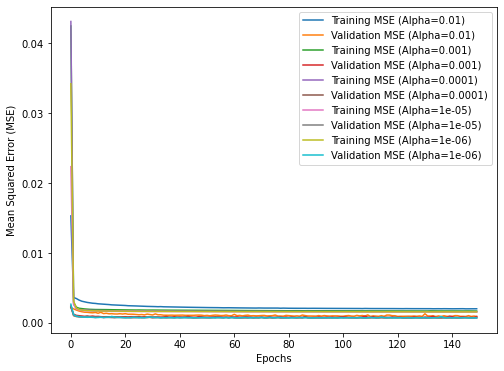

In [16]:
best_hyperparams = None
best_val_loss = float('inf')
best_model = None

def plot_training_progress(history, df_train, df_val):
    history = pd.DataFrame(history.history)

    pnl_train_bs = (calculate_pnl(df_train, df_train['delta_bs'])**2).mean()
    pnl_val_bs = (calculate_pnl(df_val, df_val['delta_bs'])**2).mean()

    hmse_train = history['mean_squared_error'] * pnl_train_bs
    hmse_val = history['val_mean_squared_error'] * pnl_val_bs

    x_min_train_hmse = hmse_train.idxmin()
    x_min_val_hmse = hmse_val.idxmin()

    f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(12, 4))
    ax1.plot(hmse_train, label='Network HMSE')
    ax1.axhline(pnl_train_bs, xmin=0, xmax=1, c='r', label='Black-Scholes HMSE')
    ax1.axvline(x_min_train_hmse, ymin=0, ymax=1,  linestyle='dashed', label='Minimum loss')
    ax1.legend()
    ax2.plot(hmse_val, label='Network HMSE')
    ax2.axhline(pnl_val_bs, xmin=0, xmax=1, c='r', label='Black-Scholes HMSE')
    ax2.axvline(x_min_val_hmse, ymin=0, ymax=1,  linestyle='dashed', label='Minimum loss')
    ax2.legend()
    plt.ylim(0., 0.01)
    ax1.set_xlim(20, history['mean_squared_error'].shape[0])
    ax2.set_xlim(20, history['mean_squared_error'].shape[0])
    plt.show()

def train_neural_network(df_train, df_val, used_features, hypers):
    global best_hyperparams, best_val_loss, best_model

    net = HedgeNet()
    if hypers['outact'] == 'normcdf':
        hypers['outact'] = normcdf
        
    net.build_model(
        (len(used_features),),
        nodes_per_layer=hypers['nodes_per_layer'],
        metrics=['mean_squared_error'],
        reg_alpha=hypers['reg_alpha'],
        lr=hypers['lr'],
        outact=hypers['outact']
    )
    history = net.fit(
        df_train, df_val,
        used_features=used_features,
        V1='V1_n',
        epochs=hypers['epochs']
    )

    val_loss = history.history['val_mean_squared_error'][-1]
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = net.model
        best_hyperparams = hypers.copy()

    clear_session()
    return history  # Return the history object

def test_selected_model(df_test, used_features, best_hyperparams):
    net = HedgeNet()
    net.build_model(
        (len(used_features),),
        nodes_per_layer=best_hyperparams['nodes_per_layer'],
        metrics=['mean_squared_error'],
        reg_alpha=best_hyperparams['reg_alpha'],
        lr=best_hyperparams['lr'],
        outact=best_hyperparams['outact']
    )
    net.model.set_weights(best_model.get_weights())  # Set the best model's weights

    delta_nn = net.calculate_delta(df_test, used_features)
    clear_session()
    return delta_nn

# Rest of the code remains the same
hypers = {
    'nodes_per_layer': (30, 30),
    'reg_alpha': 1e-4,
    'lr': 1e-4,
    'epochs': 150,
    'outact': 'relu'
}

lab_tune = 'reg_alpha'
set_of_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

# Create a dictionary to store the best hyperparameter values for each parameter
best_hyperparameter_value = {}
# Create a dictionary to store the MSE history for each alpha
mse_history = {}

def plot_training_progress(history, df_train, df_val, alphas):
    """
    Plot the training progress of the neural network for different alpha values.

    :param history: Dictionary containing the training history for different alpha values.
    :param df_train: DataFrame of the training data.
    :param df_val: DataFrame of the validation data.
    :param alphas: List of alpha values for which training progress will be plotted.
    """
    # Create a new figure and axis for the plot
    f, ax = plt.subplots(figsize=(8, 6))

    # Loop over the provided alpha values
    for alpha in alphas:
        # Get the mean squared error for training and validation at each epoch for the current alpha
        mse_train = history[alpha]['mean_squared_error']
        mse_val = history[alpha]['val_mean_squared_error']

        # Plot the training and validation MSE curves for the current alpha
        ax.plot(mse_train, label=f'Training MSE (Alpha={alpha})')
        ax.plot(mse_val, label=f'Validation MSE (Alpha={alpha})')

    # Set the labels for x and y axes
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Squared Error (MSE)')

    # Add a legend to the plot
    ax.legend()

    # Display the plot
    plt.show()


# Loop over the values to tune the hyperparameter
for value in set_of_values:
    hypers[lab_tune] = value
    # For each value, we train the network once.
    history = train_neural_network(df_train, df_val, used_features, hypers)
    mse_history[value] = history.history

    # Each train is tested once on a single Monte Carlo set.
    df_test = standardize_feature([df_test], scaler, original_features)

    delta_nn = test_selected_model(df_test, used_features, best_hyperparams)

    # We calculate NN pnl and BS pnl.
    pnl_nn = calculate_pnl(df_test, delta_nn)
    pnl_bs = calculate_pnl(df_test, df_test['delta_bs'])

    df_metrics = pd.DataFrame({'BS': [(pnl_bs**2).mean()],
                               'NN': [(pnl_nn**2).mean()]})

    # Save the best hyperparameter value for this parameter
    best_hyperparameter_value[lab_tune] = best_hyperparams[lab_tune]


# Print the best hyperparameter values for each parameter
print("Best Hyperparameter Values:")
for key, value in best_hyperparameter_value.items():
    print(f"{key}: {value}")

plot_training_progress(mse_history, df_train, df_val, set_of_values)

### Printing Hyperparameter Tuning Result

In [17]:
best_hyperparameter_value

{'reg_alpha': 1e-06}

In [18]:
df_metrics_summary = pd.DataFrame(columns=['BS'] + [f'para={v:.0e}' for v in set_of_values])

In [19]:
print('Features used:', used_features)
print('Set of Values used for Tuning:', set_of_values)
print('Best Hyperparameters:')
for k, v in best_hyperparams.items():
    print(k,v)

Features used: ['M0_t', 'tau0_implvol0_t', 'cp_int']
Set of Values used for Tuning: [0.01, 0.001, 0.0001, 1e-05, 1e-06]
Best Hyperparameters:
nodes_per_layer (30, 30)
reg_alpha 1e-06
lr 0.0001
epochs 150
outact relu


In [20]:
best_hyperparams

{'nodes_per_layer': (30, 30),
 'reg_alpha': 1e-06,
 'lr': 0.0001,
 'epochs': 150,
 'outact': 'relu'}

### Training the Neural Network

This part of the code trains the neural network model on the full training data using the best hyperparameters that were obtained through hyperparameter tuning.

Code explanation:

1. Create the `best_model` object: An instance of the `HedgeNet` class is created, which represents the neural network model used for hedging.

2. Build the model: The neural network model architecture is built using the `build_model` method. The model is constructed with the following parameters:
   - `input_shape`: The shape of the input data, which is determined by the number of features in `original_features`.
   - `nodes_per_layer`: The number of nodes in each hidden layer. The value for this parameter is taken from the best hyperparameters found during tuning.
   - `metrics`: A list of evaluation metrics to be used during training. In this case, it's set to only include the mean squared error (MSE).
   - `reg_alpha`: The regularization strength (alpha) used in the model's regularization. The value is taken from the best hyperparameters.
   - `lr`: The learning rate of the optimizer. It's also taken from the best hyperparameters.
   - `outact`: The activation function for the output layer. It's set to the best activation function found during tuning.

3. Train the model: The `fit` method is called to train the model using the training data (`df_train`) and validating it on the validation data (`df_val`). The following parameters are passed to the `fit` method:
   - `used_features`: The list of feature names that will be used as input for the model. In this case, it's set to `original_features`, which are the features used for training.
   - `V1`: The name of the target feature for the model, which is `'V1_n'`.
   - `epochs`: The number of training epochs, which is set to the best number of epochs found during tuning.

After training, the `best_model` will now contain the weights and parameters learned from the full training data using the best hyperparameters. This model is ready to be used for predicting the delta values on the test data and evaluate its performance.

In [21]:
# Train the model on the full training data using the best hyperparameters
best_model = HedgeNet()
best_model.build_model(
    (len(original_features),),
    nodes_per_layer=best_hyperparams['nodes_per_layer'],
    metrics=['mean_squared_error'],
    reg_alpha=best_hyperparams['reg_alpha'],
    lr=best_hyperparams['lr'],
    outact=best_hyperparams['outact']
)
best_model.fit(
    df_train, df_val,
    used_features=original_features,
    V1='V1_n',
    epochs=best_hyperparams['epochs']
)

Epoch 1/150
3463/3463 [==============================] - 5s 2ms/step - loss: 0.0509 - mean_squared_error: 0.0509 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 2/150
3463/3463 [==============================] - 4s 1ms/step - loss: 0.0206 - mean_squared_error: 0.0205 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 3/150
3463/3463 [==============================] - 3s 923us/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0056 - val_mean_squared_error: 0.0055
Epoch 4/150
3463/3463 [==============================] - 4s 1ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 5/150
3463/3463 [==============================] - 4s 1ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 6/150
3463/3463 [==============================] - 4s 1ms/step - loss: 0.0079 - mean_squared_error: 0.0078 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 7/

### Testing the Model

In this part of the code, the best-trained model is tested on the test data (`df_test`) using the hyperparameters that were found to be the best during the tuning process.

Code explanation:

1. Copy the test data: A copy of the test data is created and stored in `df_test_copy`. This copy is used to ensure that the original test data remains unchanged.

2. Standardize test data: The `standardize_feature` function is used to standardize the test data with the same scaler that was used for the training and validation data. The `original_features` are standardized to have zero mean and unit variance.

3. Calculate delta using the best model: The `calculate_delta` method of the `best_model` is used to calculate the delta values for the test data. The method takes the standardized test data (`df_test_copy`) and the `original_features` as input.

4. Calculate NN pnl and BS pnl: The calculated delta values (`delta_nn`) are used to calculate the profit and loss (pnl) for both the neural network model (`pnl_nn`) and the Black-Scholes model (`pnl_bs`). The pnl is calculated based on the squared difference between the predicted option price and the true option price (`delta_bs`).

5. Create a DataFrame with the results: The pnl values for the neural network model (`pnl_nn`) and the Black-Scholes model (`pnl_bs`) are used to create a DataFrame called `df_metrics`. The DataFrame contains two columns, 'BS' and 'NN', where the values represent the mean squared pnl for each model.

At this point, `df_metrics` contains the mean squared pnl for both the neural network model and the Black-Scholes model on the test data. This information can be used to compare the performance of the neural network model against the Black-Scholes model in terms of pnl.

In [31]:
# Test the best model on df_test using the best hyperparameters
df_test_copy = df_test.copy()
df_test_copy = standardize_feature(df_test_copy, scaler, original_features)

 # Standardize test data
delta_nn = best_model.calculate_delta(df_test_copy, original_features)  # Use best_model instead of creating a new instance

# Calculate NN pnl and BS pnl.
pnl_nn = calculate_pnl(df_test_copy, delta_nn)
pnl_bs = calculate_pnl(df_test_copy, df_test_copy['delta_bs'])

df_metrics = pd.DataFrame({'NN': [(pnl_nn**2).mean()]})

`df_metrics` is a DataFrame that stores the mean squared profit and loss (pnl) values for both the neural network (NN) model and the Black-Scholes (BS) model on the test data (`df_test`). It is used to compare the performance of the two models.

In [32]:
df_metrics

,NN
0,0.001534


best_hyperparams is a dictionary that stores the best hyperparameters found during the hyperparameter tuning process.

In [33]:
best_hyperparams

{'nodes_per_layer': (30, 30),
 'reg_alpha': 1e-06,
 'lr': 0.0001,
 'epochs': 150,
 'outact': 'relu'}

In [34]:
print('Random seed:', seed),
print('Features used:', used_features),
print('Neurons per layer:', best_hyperparams['nodes_per_layer']),
print('Learning rate:', best_hyperparams['lr']),
print('L2 regularization alpha:', best_hyperparams['reg_alpha']),
print('Number of training epochs:', best_hyperparams['epochs'])

Random seed: 42
Features used: ['M0_t', 'tau0_implvol0_t', 'cp_int']
Neurons per layer: (30, 30)
Learning rate: 0.0001
L2 regularization alpha: 1e-06
Number of training epochs: 150


### Plotting the Results

Now we generate a scatter plot to visualize the predicted option prices (V1) by the neural network (NN) model against the actual option prices (V1_n) from the test data (df_test_copy).

#### The insights from the scatter plot:

1. Model Accuracy: By examining how closely the points align with the diagonal line, you can assess the overall accuracy of the Neural Network model. Points close to the diagonal indicate more accurate predictions, while points away from the diagonal represent prediction errors.

2. Underestimation/Overestimation: If the points tend to cluster below or above the diagonal, it suggests that the Neural Network is systematically underestimating or overestimating option prices.

3. Prediction Range: The spread of points along the diagonal can indicate the range of option prices where the model performs well and where it struggles to make accurate predictions.

4. Outliers: Any data points that deviate significantly from the diagonal represent potential outliers where the model has difficulty capturing complex patterns.

5. Model Consistency: If the points are closely concentrated around the diagonal, it indicates that the Neural Network consistently predicts option prices close to the actual values.

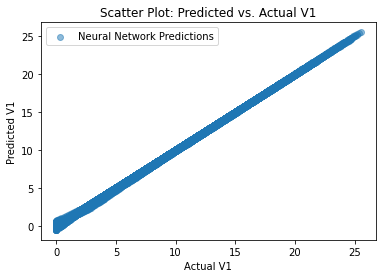

In [41]:
plt.scatter(df_test_copy['V1_n'], df_test_copy['V1_n'] + pnl_nn, label='Neural Network Predictions', alpha=0.5)
plt.xlabel('Actual V1')
plt.ylabel('Predicted V1')
plt.title('Scatter Plot: Predicted vs. Actual V1')
plt.legend()
plt.show()

The code below, plots a line chart that compares the actual portfolio value (V1) with the predictions made by the Neural Network (NN) over time.

#### Insights from time chart:

1. Model Performance: By comparing the actual portfolio value (represented by the 'Actual V1' line) with the Neural Network's predictions (represented by the 'Neural Network Predictions' line), you can assess how well the model performs in capturing the dynamics of the portfolio value over time.

2. Accuracy: If the 'Neural Network Predictions' line closely follows the 'Actual V1' line, it indicates that the Neural Network is making accurate predictions, and the model is capturing the underlying patterns in the portfolio value effectively.

3. Prediction Lag: Any deviation or delay between the 'Neural Network Predictions' line and the 'Actual V1' line could suggest that the model is lagging in reacting to changes in the portfolio value. This could be an area for improvement in the model's predictive capabilities.

4. Volatility: Differences in the slopes or fluctuations between the two lines can indicate differences in volatility estimation. If the Neural Network's predictions show more significant swings than the actual portfolio value, it may suggest that the model is overestimating volatility.

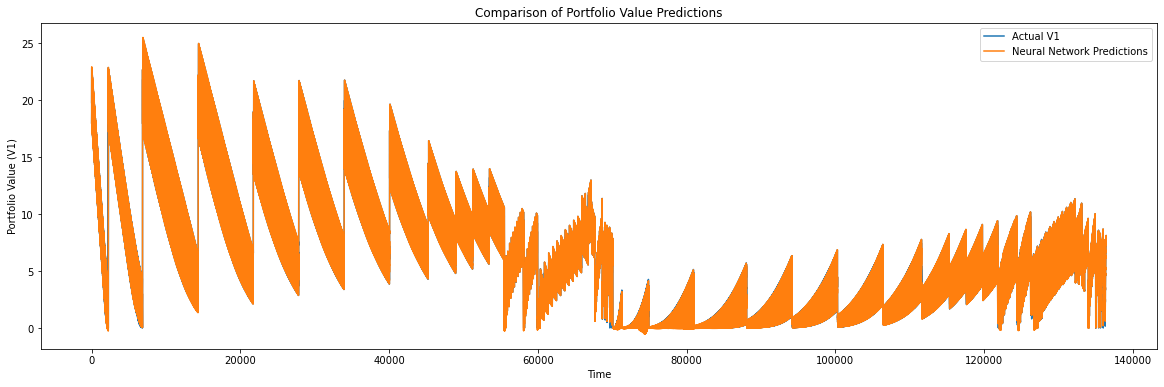

In [36]:
plt.figure(figsize=(20, 6))
plt.plot(df_test_copy['V1_n'], label='Actual V1')
plt.plot(df_test_copy['V1_n'] + pnl_nn, label='Neural Network Predictions')
plt.xlabel('Time')
plt.ylabel('Portfolio Value (V1)')
plt.title('Comparison of Portfolio Value Predictions')
plt.legend()
plt.show()

The code below is plotting a line graph with markers showing the difference between the actual portfolio value (`V1_n`) and the predicted portfolio value using the Neural Network (`V1_n + pnl_nn`) over time. The plot of the difference between the actual and predicted portfolio values provides valuable insight into the accuracy of the neural network's predictions.


#### Insights from the  difference plot:

1. Prediction Accuracy: The plot shows how well the Neural Network model is able to predict the actual V1 values. When the line is close to zero, it indicates that the predictions are accurate and align well with the actual values.

2. Model Performance Over Time: The plot provides a visual representation of the model's performance over time. It allows you to observe if there are specific periods where the model performs better or worse.

3. Trend and Patterns: Any trends or patterns in the difference between the actual and predicted values can be observed. Consistent patterns in the difference may indicate certain market conditions or data patterns where the model struggles to make accurate predictions.

4. Outliers and Anomalies: Large spikes or outliers in the difference may indicate instances where the model fails to capture certain market behaviors or faces challenges in making accurate predictions.

5. Model Evaluation: The plot can be used for model evaluation and comparison against other models or benchmarks. For example, you can overlay the performance of other models or the Black-Scholes model to see how the Neural Network model fares in comparison.

6. Identifying Improvements: If there are consistent patterns of high differences, it may suggest areas for model improvement or data preprocessing to enhance prediction accuracy.

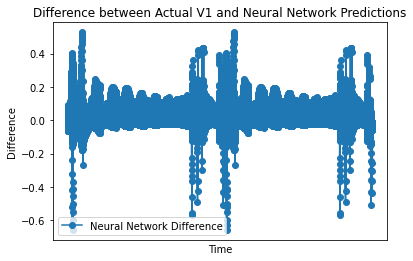

In [37]:
diff_nn = df_test_copy['V1_n'] - (df_test_copy['V1_n'] + pnl_nn)
plt.plot(diff_nn, label='Neural Network Difference', marker='o')
plt.xlabel('Time')
plt.xticks([])
plt.ylabel('Difference')
plt.title('Difference between Actual V1 and Neural Network Predictions')
plt.legend()
plt.show()

The plotted duagram below shows, "HMSE" which stands for "Hedging Mean Squared Error." It represents the mean squared error between the actual portfolio value (V1) and the portfolio value predicted by the Neural Network model after applying a hedging strategy.

#### Insights from the MSHE diagram:

1. Hedging Performance: The plot shows how well the Neural Network model's hedging strategy performs over time. A lower HMSE indicates that the model's hedging strategy is effectively reducing the risk in the portfolio.

2. Hedging Accuracy: The HMSE gives an idea of the accuracy of the hedging strategy. A lower value indicates that the model's hedging approach is better at minimizing the variance between the predicted portfolio value and the actual portfolio value.

3. Time-Varying Performance: The plot allows us to observe how the hedging performance changes over different periods. If the HMSE fluctuates significantly over time, it may suggest that the effectiveness of the hedging strategy varies with market conditions or underlying asset behavior.

4. Model Performance Evaluation: Comparing the HMSE of the Neural Network's hedging strategy against other models or benchmarks can help evaluate the effectiveness of the model's hedging approach.

5. Identification of Risky Periods: Significant spikes or peaks in HMSE may indicate periods when the hedging strategy struggled to minimize risk effectively. These periods might be associated with market volatility or specific events impacting the underlying assets.

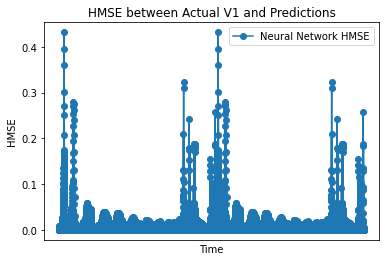

In [39]:
# Calculate HMSE for Neural Network predictions
hmse_nn = (df_test_copy['V1_n'] - (df_test_copy['V1_n'] + pnl_nn)) ** 2

# Plot HMSE values
plt.plot(hmse_nn, label='Neural Network HMSE', marker='o')
plt.xlabel('Time')
plt.ylabel('HMSE')
plt.title('HMSE between Actual V1 and Predictions')
plt.legend()
plt.xticks([])
plt.show()

In [40]:
# Print the overal HMSE
print(np.mean(hmse_nn))

0.0015342187035403355
